In [1]:
import numpy as np

from math import pi
import matplotlib.pyplot as plt
import time
from ipywidgets import FloatSlider, Button, Output, VBox, HTML, HBox, Dropdown, interact, Output, Checkbox, FloatText
from IPython.display import Image, display, clear_output, Math

from test_functions1D import MultiMinimaFunc_numpy, Sinc_numpy, Sin_numpy, DiscontinuousFunc_numpy, MultiMinimaAbsFunc_numpy


# ------------------------------------------------------------------------------------------------------------
# HJ Moreau Adaptive Descent
# ------------------------------------------------------------------------------------------------------------

class HJ_MAD:
    ''' 
        Hamilton-Jacobi Moreau Adaptive Descent (HJ_MAD) for nonconvex minimization.
        Inputs and Outputs descriptions remain unchanged.
    '''

    def __init__(self, f, x_true, x0, delta=0.1, int_samples=100, t_vec = [1.0, 1e-3, 1e1], max_iters=5e4, 
                 tol=5e-2, theta=0.9, beta=[0.9], eta_vec = [0.9, 1.1], alpha=1.0, fixed_time=False, 
                 verbose=True, accelerated=False,momentum=0.5, plot_parameters = [-30,30,None]):
      
        self.delta            = delta
        self.f                = f
        self.int_samples      = int_samples
        self.max_iters        = max_iters
        self.tol              = tol
        self.t_vec            = t_vec
        self.theta            = theta
        self.x_true           = x_true
        self.x0 = x0
        self.beta             = beta 
        self.alpha            = alpha 
        self.eta_vec          = eta_vec
        self.fixed_time       = fixed_time
        self.verbose          = verbose
        self.accelerated     = accelerated
        self.momentum = momentum
        # Plotting Parameters
        self.plot_parameters = plot_parameters

      
        # check that alpha is in right interval
        assert(alpha >= 1-np.sqrt(eta_vec[0]))
        assert(alpha <= 1+np.sqrt(eta_vec[1]))
    
    def compute_grad_uk(self, x, t, eps=1e-14):
        ''' 
            Compute the gradient of the Moreau envelope
        '''
        f = self.f
        delta = self.delta
        # Compute the function of the random variable y sampled from N(x,delta*t)
        standard_dev = np.sqrt(delta * t)
        y = standard_dev * np.random.randn(self.int_samples) + x  
        exp_term = np.exp(-f(y) / delta)

        # Compute Denominator and average over the samples (add eps for 0 error)
        v_delta = np.mean(exp_term) + eps

         # Compute Numerator and average over the samples
        numerator = np.mean(y * exp_term)

        # Compute Gradient at uk
        grad_uk = (x - numerator / (v_delta))

        # Compute estimated uk
        uk = -delta * np.log(v_delta)

        # Compute Estimated prox_xk
        prox_xk = numerator / v_delta

        # Compute the standard error for uk
        sample_var = np.var(-delta *np.log(exp_term+ eps), ddof=1)  # Sample Variance
        se_uk = np.sqrt(sample_var) / np.sqrt(self.int_samples) # Standard Error

        # Return Gradient at uk, uk, prox at xk and standard error in uk sample
        return prox_xk, grad_uk, uk, se_uk


    def update_time(self, tk, rel_grad_uk_norm):
        '''
            time step rule

            if ‖gk_plus‖≤ theta (‖gk‖+ eps):
            min (eta_plus t,T)
            else
            max (eta_minus t,t_min) otherwise

            OR:
            
            if rel grad norm too small, increase tk (with maximum T).
            else if rel grad norm is too "big", decrease tk with minimum (t_min)
        '''

        eta_minus = self.eta_vec[0]
        eta_plus = self.eta_vec[1]
        T = self.t_vec[2]
        t_min = self.t_vec[1]

        if rel_grad_uk_norm <= self.theta:
            # increase t when relative gradient norm is smaller than theta
            tk = min(eta_plus*tk , T)
        else:
            # decrease otherwise t when relative gradient norm is smaller than theta
            tk = max(eta_minus*tk, t_min)

        return tk
    
    def gradient_descent(self, xk, tk):
        # Compute prox and gradient
        prox_xk, grad_uk, _, _ = self.compute_grad_uk(xk, tk)

        # Perform gradient descent update
        xk_plus1 = xk - self.alpha * (xk-prox_xk)

        return xk_plus1, grad_uk

    def run(self, animate,plot_bool=True):
        xk_hist = np.zeros(self.max_iters)
        xk_error_hist = np.zeros(self.max_iters)
        rel_grad_uk_norm_hist = np.zeros(self.max_iters)
        fk_hist = np.zeros(self.max_iters)
        tk_hist = np.zeros(self.max_iters)

        xk = self.x0
        x_opt = xk
        tk = self.t_vec[0]
        t_max = self.t_vec[2]

        _, grad_uk, _, _  = self.compute_grad_uk(xk, tk)
        rel_grad_uk_norm = 1.0

        if self.accelerated:
            xk_minus_1 = xk


        fmt = '[{:3d}]: fk = {:6.2e} | xk_err = {:6.2e} '
        fmt += ' | |grad_uk| = {:6.2e} | tk = {:6.2e}'

        for k in range(self.max_iters):
            
            # Update History
            xk_hist[k] = xk
            rel_grad_uk_norm_hist[k] = rel_grad_uk_norm
            xk_error_hist[k] = np.linalg.norm(xk - self.x_true)
            tk_hist[k] = tk
            fk_hist[k] = self.f(xk)


            if animate:
                self.plot(k, xk, tk,xk_error_hist[k])
                time.sleep(0.5)

            if self.verbose:
                print(fmt.format(k + 1, fk_hist[k], xk_error_hist[k], rel_grad_uk_norm_hist[k], tk))

            if xk_error_hist[k] < self.tol:
                tk_hist = tk_hist[:k + 1]
                xk_hist = xk_hist[:k + 1]
                xk_error_hist = xk_error_hist[:k + 1]
                rel_grad_uk_norm_hist = rel_grad_uk_norm_hist[:k + 1]
                fk_hist = fk_hist[:k + 1]

                print('-------------------------- HJ-MAD RESULTS ---------------------------')
                print('HJ-MAD converged with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
                print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist) * self.int_samples)
                
                break
            elif k == self.max_iters - 1:
                print('-------------------------- HJ-MAD RESULTS ---------------------------')
                print('HJ-MAD failed to converge with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
                print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist) * self.int_samples)
                print('Used fixed time = ', self.fixed_time)

            if k > 0:
                if fk_hist[k] < fk_hist[k - 1]:
                    x_opt = xk

            grad_uk_norm_old = np.linalg.norm(grad_uk)

            # Accelerate
            if self.accelerated and k > 0:
                yk = xk + self.momentum * (xk - xk_minus_1)
                xk_minus_1 = xk
            else:
                yk=xk
            # Perform GD
            xk, grad_uk = self.gradient_descent(yk,tk)
    
            # Compute Relative Grad Uk
            grad_uk_norm = np.linalg.norm(grad_uk)
            rel_grad_uk_norm = grad_uk_norm / (grad_uk_norm_old + 1e-12)

            if not self.fixed_time:
                tk = self.update_time(tk, rel_grad_uk_norm)


        if plot_bool:
            self.plot(k,xk, tk,xk_error_hist[k],plot_bool)

        algorithm_hist = (xk_hist, tk_hist, xk_error_hist, rel_grad_uk_norm_hist, fk_hist)
                     
        return x_opt, algorithm_hist
    

    def plot(self, k, xk, tk,error,plot_bool=True):
        intervalx_a, intervalx_b,plot_output = self.plot_parameters

        # Use the selected global function to compute f_values
        x_range = np.linspace(intervalx_a, intervalx_b, 500)  # Adjust based on selected function
        f_values = np.array([self.f(x) for x in x_range])

        # Calculate Moreau envelope at xk
        prox_xk, _, uk, se_uk  = self.compute_grad_uk(xk, tk)
        #xk_plus1 = xk - self.alpha * grad_uk
        #estimated_moreau_value = self.f(prox_xk) + (1 / (2 * tk)) * ((prox_xk - xk) ** 2)

        # Compute the Error
        #xk_plus1 = xk - self.alpha * grad_uk
        if k==0:
            error = np.linalg.norm(self.x0 - self.x_true) 

        # The function that prox minimizes
        prox_func_values = np.array([self.f(x) + (1 / (2 * tk)) * (x - xk) ** 2 for x in x_range])

        # Plot f(x) 
        plt.figure(figsize=(10, 6))
        plt.plot(x_range, f_values, label='f(x)', color='black')

        # Plot the function that prox minimizes at xk and its estimated minima
        plt.plot(x_range, prox_func_values, label=r'$f(x) + \frac{1}{2T} (x - x_k)^2$', color='orange')
        plt.scatter(prox_xk, self.f(prox_xk) + (1 / (2 * tk)) * (prox_xk - xk) ** 2,
                    facecolors='none',edgecolors='orange', label=r'Estimated Prox at $ x_k$, $prox_{tf}(x_k)\approx x_k-t_k\nabla u^{\delta}(x_k)$ and' +
                    f'\nthe Estimated Global Minima of ' + r'$f(x) + \frac{1}{2t_k} (x - x_k)^2$',
                    s=100, zorder=4, marker='s')

        # Plot Moreau Envelope Estimation with error bars
        plt.errorbar(xk, uk, yerr=se_uk, label=rf'Estimate Moreau Envelope Value, $u(x_k,t_k))$, where $t_k={tk:.1f}$',
                 color='red', fmt='o', markersize=5, zorder=4, marker='x', capsize=5)

        # Plot Points for Current, Next, Initial Iteration, and Global Minima
        plt.scatter(xk, self.f(xk), label=r'Current Iteration, $f(x_k)$', zorder=3, marker='^')
        plt.scatter(self.x0, self.f(self.x0), color='green', label=r'Initial Iteration, $f(x_0)$',s=100, zorder=4, facecolors='none',edgecolors='blue')
        plt.scatter(self.x_true, self.f(self.x_true), color='black', label=r'Global Minima, $f(x_{true})$',s=100, zorder=5, marker='x')
        #plt.scatter(xk_plus1, self.f(xk_plus1), color='cyan', zorder=4, label=r'Next Iteration, $f(x_{k+1})$', marker='^')

        plt.title(f'f(x) and Moreau Envelope\nIteration {k}, Error={error:.3e}, Tol={self.tol:.3e}')
        plt.xlabel('x')
        plt.ylabel('Function Value')

        # Set limits and grid
        plt.xlim(intervalx_a, intervalx_b)

        # Dynamically set the y-limits based on function outputs
        y_min = np.min(f_values)
        y_max = np.max(f_values)

        if y_max < 0:
            # If all values are negative, set the limits to give some visual space
            plt.ylim(1.2 * y_min, 0)  # Set lower limit 20% below min, upper limit at 0
        elif y_min > 0:
            plt.ylim(0.8 * y_min, 1.2 * y_max)  # 20% less than the min if min is positive
        else:
            plt.ylim(1.2 * y_min, 1.2 * y_max)  # 20% more than the min if min is zero or negative

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=1)
        plt.grid(which='major', linestyle='-', linewidth='0.5')
        plt.minorticks_on()
        plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
        plt.grid(which='minor', linestyle=':', linewidth='0.5')

        # Save the figure as a PNG file
        plt.savefig("MAD_interactive_plot.png", format='png', bbox_inches='tight')
        plt.close()  # Close the plot to free up memory

        if plot_bool:
            with plot_output:
                clear_output(wait=True)  # Clear previous plot
                display(Image(filename="MAD_interactive_plot.png"))



In [2]:
# ------------------------------------------------------------------------------------------------------------
# UI Class to Interact with HJ_MAD
# ------------------------------------------------------------------------------------------------------------

class HJ_MAD_UI:
    def __init__(self):
        self.init_hj_mad()
        self.create_ui()

    def init_hj_mad(self):
        # Output widget to display the plot
        self.plot_output = Output()
        self.plot_results_output = Output()

        # Fixed Variables
        tol = 5e-4
        eta_min = 0.9
        eta_plus = 5.0
        eta_vec = [eta_min, eta_plus]
        theta = 1.0
        beta = 0.0
        self.t_min = 0.1

        # Set Initial Interactive Values
        int_samples = int(200)
        delta = 0.1
        t_init = 220
        t_max = 230
        max_iters = int(50)
        alpha = 0.1

        # Default Function Settings
        intervalx_a, intervalx_b = -30, 30
        plot_parameters = [intervalx_a, intervalx_b,self.plot_output]
        f = MultiMinimaFunc_numpy
        x_true = -1.51034568
        self.gamma = 1.89777
        x0 = -30

        # Create HJ_MAD instance with initial parameters
        self.hj_mad = HJ_MAD(f=f, x_true=x_true, x0=x0, delta=delta, int_samples=int_samples, 
                             t_vec=[t_init, self.t_min, t_max], max_iters=max_iters, tol=tol, 
                             theta=theta, beta=beta, eta_vec=eta_vec, alpha=alpha, 
                             fixed_time=False, verbose=False, accelerated=False,
                             plot_parameters=plot_parameters)

    def update_hj_mad_delta(self,b):
        self.hj_mad.delta = self.delta_slider.value
        self.plot_hj_mad()
        self.update_standard_error_display()

    def update_hj_mad_int_samples(self,b):
        self.hj_mad.int_samples = int(self.int_samples_slider.value)
        self.plot_hj_mad()
        self.update_standard_error_display()

    def update_hj_mad_t_init(self,b):
        self.hj_mad.t_vec[0] = self.t_init_slider.value

        # Don't let t_max become smaller than t_init
        if self.t_max_slider.value < self.t_init_slider.value:
            self.t_max_slider.value = self.t_init_slider.value
        self.plot_hj_mad()
        self.update_standard_error_display()

    def update_hj_mad_t_max(self,b):
        self.hj_mad.t_vec[2] = self.t_max_slider.value

        # Don't let t_max become smaller than t_init
        if self.t_max_slider.value < self.t_init_slider.value:
            self.t_init_slider.value = self.t_max_slider.value
        self.update_standard_error_display()

    def update_hj_mad_max_iters(self,b):
        self.hj_mad.max_iters = int(self.max_iters_slider.value)

    def update_hj_mad_alpha(self,b):
        self.hj_mad.alpha = self.alpha_slider.value

    def update_hj_mad_momentum(self,b):
        self.hj_mad.momentum = self.momentum_slider.value

    def update_t_threshold_display(self):
        """Update the display for the t_threshold and compute its value."""

        # Create the HTML string
        html_content = """
        <div style="border: 1px solid black; padding: 10px; border-radius: 5px; margin-top: 10px;">
        <h4 style="margin: 0;">Time Threshold <i>(Theoretical Lower Bound on Intial Time Steps for Convergence)</i></h4>
        <div style="font-family: Times New Roman, serif; font-size: 14px;">
            <p><strong>t<sub>threshold</sub> = {}
        """

        # Calculate t_threshold
        if self.gamma is not None:
            self.t_threshold = (np.linalg.norm(self.hj_mad.x_true - self.x_0_slider.value)**2) / (2 * self.gamma)
            # Use str.format to insert the calculated value into html_content
            html_content = html_content.format(f"{self.t_threshold:.2f}, where</strong>:</p>")
        else:
            # If self.gamma is None, modify html_content to show 'UnDefined'
            self.t_threshold_display.value = html_content.format('UnDefined</p>')
            return

        # Make sure t_min is less that t_threshold (this isn't a necessary 
        # condition as long as t_min<=t_init but this gives the user more choice)
        if self.t_threshold < self.t_min:
            self.t_min = self.t_threshold*0.8
            self.t_max_slider.min = self.t_min
            self.t_max_slider.min = self.t_min

        if self.t_threshold > self.t_max_slider.max:
            self.t_max_slider.max = self.t_threshold*1.5
            self.t_init_slider.max = self.t_threshold*1.5
        else:
            self.t_max_slider.max = 100
            self.t_init_slider.max = 100 

        if self.hj_mad.fixed_time:
            html_content += f"""<p style="margin-left: 20px;">
                • t<sub>0</sub> ≥ ||x* - x<sub>0</sub>||<sup>2</sup> / (2γ) = t<sub>threshold</sub>
            </p>
            </div>
            </div>"""
            # Update the display
            self.t_threshold_display.value = html_content
            return
        
        html_content += f""" <p style="margin-left: 20px;">
                • T ≥ t<sub>0</sub> ≥ ||x* - x<sub>0</sub>||<sup>2</sup> / (2γ) = t<sub>threshold</sub>
            </p>
            <p style="margin-left: 20px;">
                • Also T ≥ t<sub>0</sub> ≥ τ > 0, τ = {self.t_min:.2f}
            </p>
            <p style="margin-left: 20px;">• T, max time. τ, min time. t<sub>0</sub>, initial time. </p>
        </div>
        </div>
        """
        # Update the display
        self.t_threshold_display.value = html_content

    def update_standard_error_display(self):
        """
        Standard Error is a measure of how much the sample mean will vary from 
        sample to sample.
        """
        # Compute the standard Deviation and Standard Error at Initial Time
        _, _, _, se_uk = self.hj_mad.compute_grad_uk(self.x_0_slider.value, self.t_init_slider.value)

        self.standard_error_display.value = f"""
            <div style="border: 1px solid black; padding: 10px; border-radius: 5px; margin-top: 10px;">
                <h4 style="margin: 0;">Standard Error for u<sub>k</sub> <i>(Variation Of The Sample Mean Between Samples)</i></h4>
            <div style="font-family: Times New Roman, serif; font-size: 14px;">
                <p><strong>Standard Error = <sup>σ</sup>/<sub>/√n</sub> = {se_uk:.4e}, where</strong>:</p>
                    <p style="margin-left: 20px;">• SE is Standard Error.</p>
                    <p style="margin-left: 20px;">• σ is the Standard Deviation(depends on δ, t, f and x).</p>
                    <p style="margin-left: 20px;">• n is the sample size.</p>
            </div>
            </div>
            """

    def update_hj_mad_x0(self,b):
        self.hj_mad.x0 = self.x_0_slider.value
        self.update_t_threshold_display()
        self.plot_hj_mad()

    def update_function(self, change):
        # Update the selected function based on dropdown selection
        if change['new'] == 'Sinc':
            intervalx_a, intervalx_b = -20, 20
            self.hj_mad.plot_parameters = [intervalx_a, intervalx_b,self.plot_output]
            self.hj_mad.f = Sinc_numpy
            self.hj_mad.x_true = 4.49341
            self.gamma = 0.1259
        elif change['new'] == 'Sin':
            intervalx_a, intervalx_b = -3.5 * pi, 2.5 * pi
            self.hj_mad.plot_parameters = [intervalx_a, intervalx_b,self.plot_output]
            self.hj_mad.f = Sin_numpy
            self.hj_mad.x_true = -np.pi / 2
            self.gamma = None
        elif change['new'] == 'MultiMinimaAbsFunc':
            intervalx_a, intervalx_b = -15, 15
            self.hj_mad.plot_parameters = [intervalx_a, intervalx_b,self.plot_output]
            self.hj_mad.f = MultiMinimaAbsFunc_numpy
            self.hj_mad.x_true = 2
            self.gamma = 1.43457
        elif change['new'] == 'DiscontinuousFunc':
            intervalx_a, intervalx_b = -15, 15
            self.hj_mad.plot_parameters = [intervalx_a, intervalx_b,self.plot_output]
            self.hj_mad.f = DiscontinuousFunc_numpy
            self.hj_mad.x_true = 2
            self.gamma = 7
        else:  # change['new'] == 'MultiMinimaFunc'
            intervalx_a, intervalx_b = -30, 30
            self.hj_mad.plot_parameters = [intervalx_a, intervalx_b,self.plot_output]
            self.hj_mad.f = MultiMinimaFunc_numpy
            self.hj_mad.x_true = -1.51034568
            self.gamma = 1.89777

        # Update the slider range for x_0 based on the new function
        self.x_0_slider.min = intervalx_a
        self.x_0_slider.max = intervalx_b
        self.x_0_slider.value = (intervalx_a + intervalx_b) / 2

        self.update_t_threshold_display()
        self.update_standard_error_display()
        self.plot_results_output.clear_output()  # Clear previous results
        self.plot_hj_mad()
    
    def update_fixed_time(self, change):
        """
        Update the fixed time state based on the checkbox.
        """
        self.hj_mad.fixed_time = change['new']
        # self.update_standard_error_display()
        # self.update_t_threshold_display()

    def update_acceleration(self, change):
        """
        Update the accelerated state based on the checkbox.
        """
        self.hj_mad.accelerated = change['new']

    def run(self, animate):
        self.plot_results_output.clear_output()  # Clear previous results
        # Run optimization with current slider values
        print('-------------------------- RUNNING HJ-MAD ---------------------------')
        print('For the parameters:')
        self.print_slider_values()

        _, algorithm_hist = self.hj_mad.run(animate=animate)
        
        self.plot_results(algorithm_hist)
        display(Image(filename="MAD_interactive_plot.png"))

    def plot_hj_mad(self):
        self.hj_mad.plot(0, self.hj_mad.x0, self.hj_mad.t_vec[0],0)
    
    def plot_results(self, algorithm_hist):
        # Unpack general case and accelerated case histories
        non_acc_algorithm_hist = None

        if self.hj_mad.accelerated:
            self.hj_mad.accelerated = False
            _, non_acc_algorithm_hist = self.hj_mad.run(animate=False,plot_bool=False)
            _, non_acc_tk_hist, non_acc_xk_error_hist, non_acc_rel_grad_uk_norm_hist, non_acc_fk_hist = non_acc_algorithm_hist
            acc_string = ' (Accelerated)'
            self.hj_mad.accelerated = True
        else:
            acc_string = ' (Non-Accelerated)'
        
        _, tk_hist, xk_error_hist, rel_grad_uk_norm_hist, fk_hist = algorithm_hist

        plt.figure(figsize=(10, 8))

        # Error history subplot
        plt.subplot(2, 2, 1)
        plt.semilogy(xk_error_hist, label='Error History'+acc_string, color='blue')
        if non_acc_algorithm_hist is not None:
            plt.semilogy(non_acc_xk_error_hist, label='Error History (Non-Accelerated)', color='orange', linestyle='--')
        plt.title('Error History')
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.legend()

        # f(k) history subplot
        plt.subplot(2, 2, 2)
        plt.plot(fk_hist, label='f(k) History'+acc_string, color='blue')
        if non_acc_algorithm_hist is not None:
            plt.plot(non_acc_fk_hist, label='f(k) History (Non-Accelerated)', color='orange', linestyle='--')
        plt.title('f(k) History')
        plt.xlabel('Iterations')
        plt.ylabel('f(k)')
        plt.legend()

        # t(k) history subplot
        plt.subplot(2, 2, 3)
        plt.semilogy(tk_hist, label='t(k) History'+acc_string, color='blue')
        if non_acc_algorithm_hist is not None:
            plt.semilogy(non_acc_tk_hist, label='t(k) History (Non-Accelerated)', color='orange', linestyle='--')
        plt.title('t(k) History')
        plt.xlabel('Iterations')
        plt.ylabel('t(k)')
        plt.legend()

        # Relative gradient norm history subplot
        plt.subplot(2, 2, 4)
        plt.loglog(rel_grad_uk_norm_hist, label='Rel. Grad Norm'+acc_string, color='blue')
        if non_acc_algorithm_hist is not None:
            plt.loglog(non_acc_rel_grad_uk_norm_hist, label='Rel. Grad Norm (Non-Accelerated)', color='orange', linestyle='--')
        plt.title('Relative Gradient Norm History')
        plt.xlabel('Iterations')
        plt.ylabel('Relative Gradient Norm')
        plt.legend()

        plt.tight_layout()  # Adjust the layout
        plt.savefig("MAD_combined_history_plot.png", format='png', bbox_inches='tight')
        plt.show()
        plt.close()  # Free up memory

        # Display the latest saved plot
        with self.plot_results_output:
            clear_output(wait=True)  # Clear previous plot
            display(Image(filename="MAD_combined_history_plot.png"))

    def reset_plot(self):
        """Reset the plot and hide the plot results."""
        self.plot_hj_mad()
        self.plot_results_output.clear_output()  # Clear previous results
        #self.plot_results_output = None  # Reset the plot results
    
    def tol_input_update(self, _):
        self.hj_mad.tol = self.tol_input.value

    def print_slider_values(self):
        """Print the values of the sliders and selected function in a rotated table format."""
        function_name = self.function_dropdown.value
        slider_values = {
            'x_0': self.x_0_slider.value,
            't_init': self.t_init_slider.value,
            't_max': self.t_max_slider.value,
            'delta': self.delta_slider.value,
            'int_samples': self.int_samples_slider.value,
            'max_iters': self.max_iters_slider.value,
            'alpha': self.alpha_slider.value,
            't_threshold': self.t_threshold
        }

        # Create a smaller HTML table in rotated format
        html_content = "<h3>Slider Values and Function Name</h3><table style='border-collapse: collapse; width: 50%; font-size: 14px;'><tr><th style='border: 1px solid black;'><strong>Parameter</strong></th><th style='border: 1px solid black;'><strong>Value</strong></th></tr>"
        
        # Add each parameter and its value as a new row
        for param, value in slider_values.items():
            html_content += f"<tr><td style='border: 1px solid black;'>{param}</td><td style='border: 1px solid black;'>{value:.2f}</td></tr>"
        
        # Add the function name at the end
        html_content += f"<tr><td style='border: 1px solid black;'>Function</td><td style='border: 1px solid black;'>{function_name}</td></tr>"
        html_content += "</table>"

        # Display the table
        display(HTML(html_content))

    def create_ui(self):
        # Title and Section Headers:
        title = HTML("<h2>HJ Moreau Adaptive Descent Visualization (in 1D)</h2>")
        internal_parameters = HTML("<h3>Internal Parameters:</h3>")
        initial_conditions = HTML("<h3>Initial Conditions Parameters:</h3>")
        
        # Dropdown to select the function
        self.function_dropdown = Dropdown(
            options=['Sinc', 'Sin', 'MultiMinima','MultiMinimaAbsFunc', 'DiscontinuousFunc'],
            value='MultiMinima',
            description='Function:',
            tooltip='Select the mathematical function to optimize.'
        )
        
        # Sliders for parameters, initialized with default values
        self.x_0_slider = FloatSlider(value=self.hj_mad.x0, min=self.hj_mad.plot_parameters[0], max=self.hj_mad.plot_parameters[1], step=0.01, description=r'x_0:', tooltip='Adjust the initial position.')
        self.delta_slider = FloatSlider(value=self.hj_mad.delta, min=0, max=5.0, step=0.005, description='Viscosity, δ:', tooltip='Adjust the viscosity parameter.')
        self.int_samples_slider = FloatSlider(value=self.hj_mad.int_samples, min=2, max=1000, step=1, description='Samples, n:', tooltip='Select the number of samples.')
        self.t_max_slider = FloatSlider(value=self.hj_mad.t_vec[2], min=self.t_min, max=100, step=0.1, description='Max t, T:', tooltip='Set the maximum time for the optimization.')
        self.t_init_slider = FloatSlider(value=self.hj_mad.t_vec[0], min=self.t_min, max=100, step=0.1, description='Initial t, t₀:', tooltip='Set the initial time for the optimization.')
        self.max_iters_slider = FloatSlider(value=self.hj_mad.max_iters, min=1, max=100, step=1, description='Max Iter., N:', tooltip='Set the maximum number of iterations.')
        self.alpha_slider = FloatSlider(value=self.hj_mad.alpha, min=0.01, max=1.99, step=0.01, description='Step Size, α:', tooltip='Adjust the step size for optimization.')
        self.momentum_slider = FloatSlider(value=self.hj_mad.momentum, min=0.01, max=2, step=0.01, description='Momentum:', tooltip='Adjust the momentum for optimization.')
        
        # Value input for tolerence
        self.tol_input = FloatText(value=self.hj_mad.tol, description='tol:', tooltip='Set the tolerence for optimization.')
        self.plot_hj_mad()

        # Checkbox for fixed time and acceleration
        self.fixed_time_checkbox = Checkbox(value=False, description='Fixed Time', tooltip='Check to use fixed time for optimization.')
        self.acceleration_checkbox = Checkbox(value=False, description='Acceleration', tooltip='Check to use Accelerated GD for optimization.')

        # Buttons to run optimization
        self.run_button = Button(description='Run Optimization', tooltip='Start the optimization process.')
        self.animation_button = Button(description='Run Animation', tooltip='Start the animation of the optimization process.')
        self.reset_plot_button = Button(description='Reset Plot', tooltip='Reset the plot to the initial state.')

        # Bind slider changes to specific update methods
        self.delta_slider.observe(self.update_hj_mad_delta, names='value')
        self.int_samples_slider.observe(self.update_hj_mad_int_samples, names='value')
        self.t_init_slider.observe(self.update_hj_mad_t_init, names='value')
        self.t_max_slider.observe(self.update_hj_mad_t_max, names='value')
        self.max_iters_slider.observe(self.update_hj_mad_max_iters, names='value')
        self.alpha_slider.observe(self.update_hj_mad_alpha, names='value')
        self.momentum_slider.observe(self.update_hj_mad_momentum, names='value')
        self.x_0_slider.observe(self.update_hj_mad_x0, names='value')

        # Bind tolerence input changes to specific update methods
        self.tol_input.observe(self.tol_input_update, names='value')

        # Dropdown event listener to update the selected function
        self.function_dropdown.observe(self.update_function, names='value')

        # Checkbox event listener to update the fixed time state
        self.fixed_time_checkbox.observe(self.update_fixed_time, names='value')
        self.acceleration_checkbox.observe(self.update_acceleration, names='value')
        
        # Initialize t_threshold_display and standard_error_display
        self.t_threshold_display = HTML("")
        self.standard_error_display = HTML("")
        self.update_t_threshold_display()
        self.update_standard_error_display()

        # Bind button clicks to the respective methods
        self.run_button.on_click(lambda b: self.run(animate=False))
        self.animation_button.on_click(lambda b: self.run(animate=True))
        self.reset_plot_button.on_click(lambda b: self.reset_plot())

        # Display the UI
        ui = VBox([title, internal_parameters, self.function_dropdown, 
                HBox([self.delta_slider, self.int_samples_slider, self.t_max_slider]), 
                HBox([self.max_iters_slider, self.alpha_slider,self.momentum_slider]),
                HBox([self.tol_input, self.fixed_time_checkbox, self.acceleration_checkbox]),
                initial_conditions, 
                HBox([self.t_init_slider, self.x_0_slider]),
                HBox([self.standard_error_display, self.t_threshold_display]),
                HBox([self.run_button, self.animation_button,self.reset_plot_button]), # instructions,
                HBox([self.plot_output,self.plot_results_output])])  # Add plot output to the UI
        display(ui)




-------------------------- RUNNING HJ-MAD ---------------------------
For the parameters:


HTML(value="<h3>Slider Values and Function Name</h3><table style='border-collapse: collapse; width: 50%; font-…

-------------------------- HJ-MAD RESULTS ---------------------------
HJ-MAD failed to converge with rel grad norm 9.75e-01
iter =  49 , number of function evaluations =  10000
Used fixed time =  False


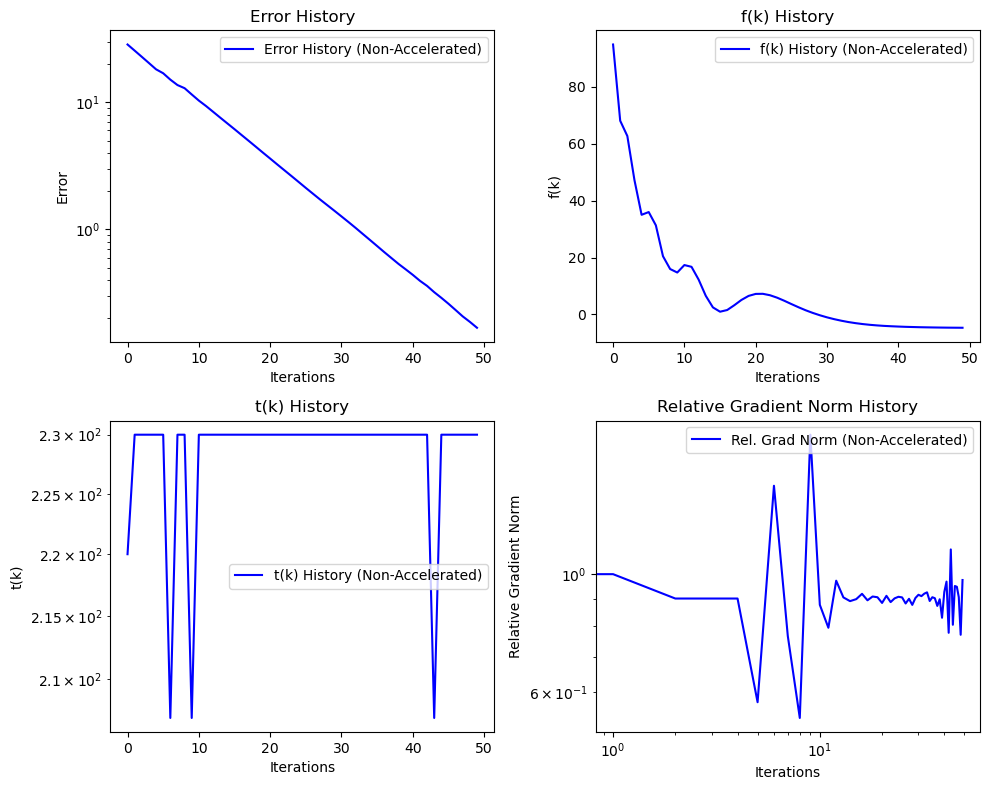

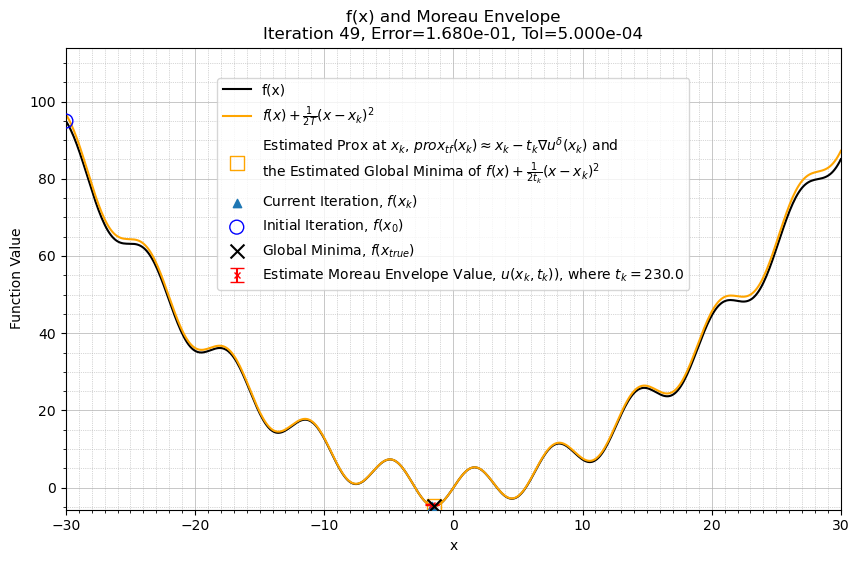

-------------------------- RUNNING HJ-MAD ---------------------------
For the parameters:


HTML(value="<h3>Slider Values and Function Name</h3><table style='border-collapse: collapse; width: 50%; font-…

-------------------------- HJ-MAD RESULTS ---------------------------
HJ-MAD converged with rel grad norm 4.26e-01
iter =  35 , number of function evaluations =  7200


-------------------------- HJ-MAD RESULTS ---------------------------
HJ-MAD failed to converge with rel grad norm 8.71e-01
iter =  49 , number of function evaluations =  10000
Used fixed time =  False


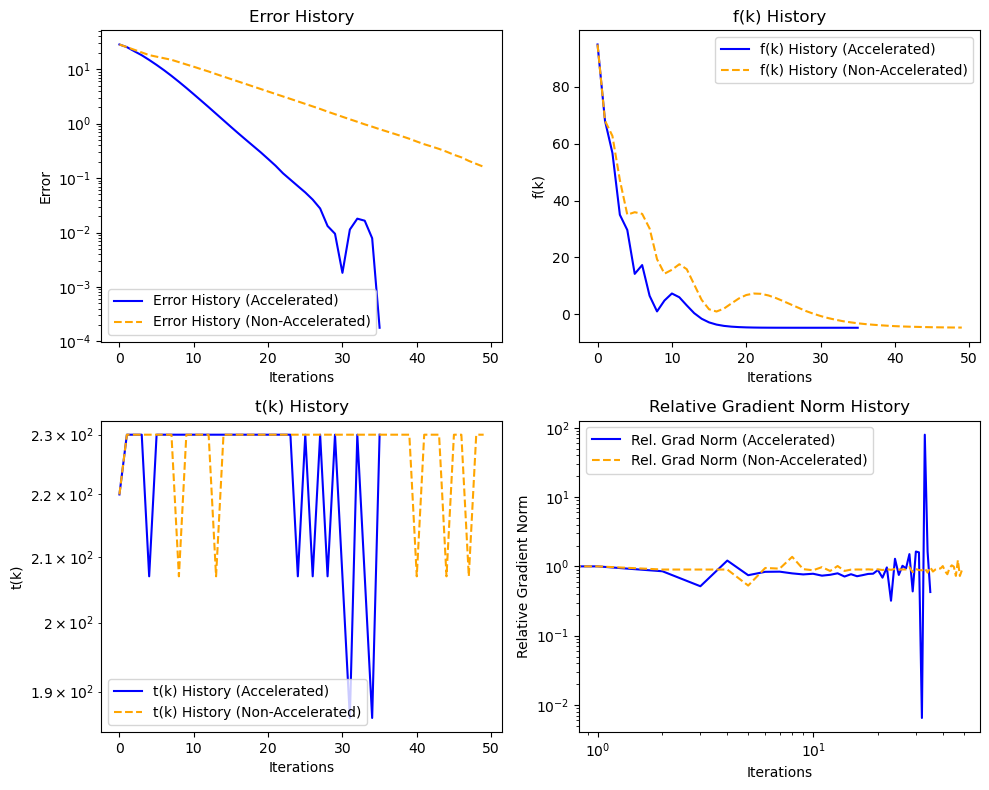

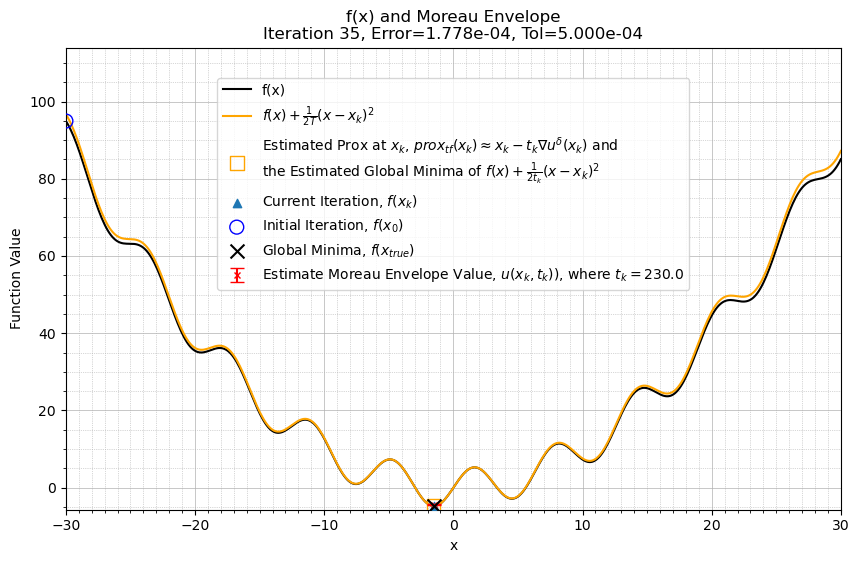

In [3]:
UI= HJ_MAD_UI()
